In [1]:
from model import UNET
from util import *
import tensorflow as tf
import numpy as np
import sklearn as sk
import pickle

import os
import tarfile

In [2]:
dataPath = os.path.join(".","Data","Images")
maskPath = os.path.join(".","Data","Segmentation")
dataType = "*.png"

SEED = 42
DATA_SPLIT = 1

OPTIMIZER = "adam"
LOSS = "binary_crossentropy"
METRICS = ["accuracy"]
BATCH_SIZE = 16
IMAGE_SHAPE = (512,512,1)
KFOLD  = 3 #MUST BE >=2
EPOCHS = 2


In [3]:
if not os.path.isdir(dataPath) or not os.path.isdir(maskPath):
    #untar the data if it hasnt been
    print("UNZIPPING DATA")
    with tarfile.open(os.path.join(".","Data","data.tar.gz")) as file:
        file.extractall(os.path.join(".","Data"))


image augmentation
Metal device set to: Apple M1 Pro


2022-03-12 11:44:00.148288: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-12 11:44:00.148406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-12 11:44:00.318637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-12 11:44:00.318891: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


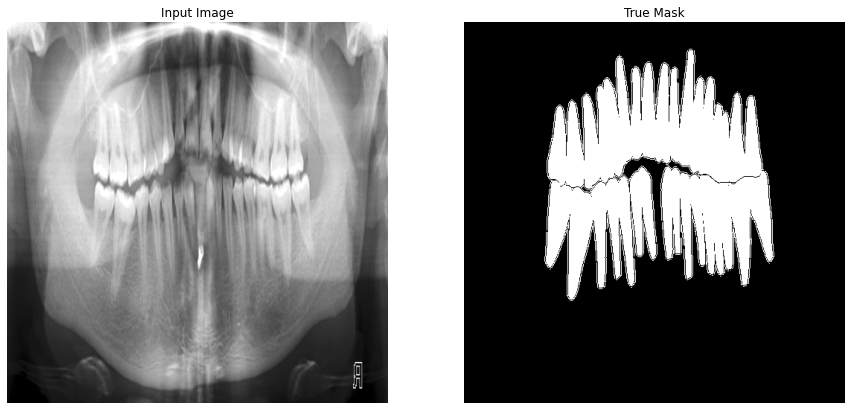

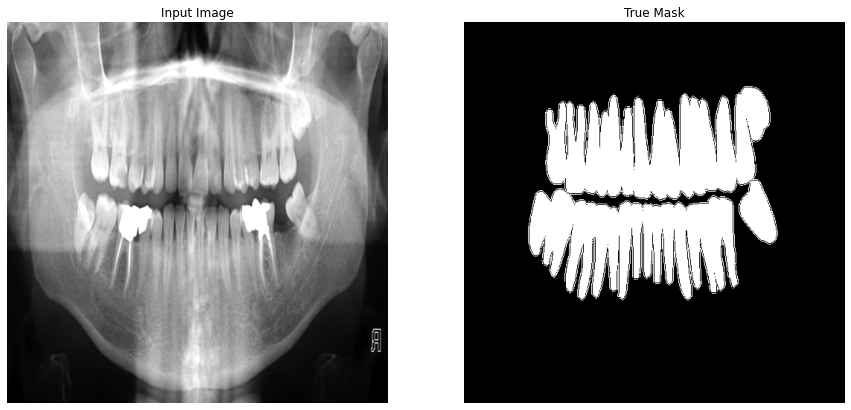

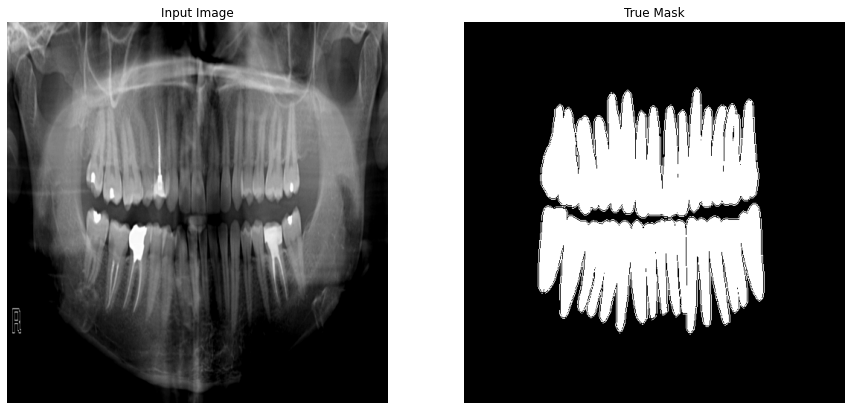

In [4]:
# LOAD DATASET AS TF DATASET
dataset = generate_dataset(dataPath, dataType, seed=SEED, img_shape = IMAGE_SHAPE, batch_size = BATCH_SIZE,
                          kfold = KFOLD, repeat_count = 1)
for element in dataset[0].take(1): #take a batch
    for b in range(min(3,BATCH_SIZE)): #now have a tuple
        display_mask_image([element[0][b],element[1][b]])


In [5]:
def learn_with_cv(folds,enable_status, repeat):
    dataset = generate_dataset(dataPath, dataType, seed=SEED, img_shape = IMAGE_SHAPE, batch_size = BATCH_SIZE,
                          kfold = folds, repeat_count = repeat, enable_augmentation = enable_status)
    histories = []
    for k in range(folds):
        print("Doing k-fold {} of {}".format(k+1,folds))
        test_dataset = dataset[k]
        train_datasets = []
        for k2 in range(folds):
            if k2 == k:
                continue
            train_datasets.append(dataset[k2])
        train_dataset = train_datasets[0]
        for ds in train_datasets[1:]:
            train_dataset = train_dataset.concatenate(ds)

        model = UNET(input_shape = IMAGE_SHAPE)
        model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
        history = model.fit(train_dataset, validation_data = test_dataset, \
                                epochs = EPOCHS, verbose = 1)
        histories.append(history.history)

    history  = {}
    history["loss"] = np.mean([hstry["loss"] for hstry in histories],axis=0)
    history["accuracy"] = np.mean([hstry["accuracy"] for hstry in histories],axis=0)
    history["val_loss"] = np.mean([hstry["val_loss"] for hstry in histories],axis=0)
    history["val_accuracy"] = np.mean([hstry["val_accuracy"] for hstry in histories],axis=0)
    return history

In [8]:
things2enable = {"nothing" : (0,0,0,0,0,0), "brightness":(0,1,0,0,0,0), "flip": (1,0,0,0,0,0), "both":(1,1,0,0,0,0)}
EPOCHS = 150
folds = 5
for en in things2enable.keys():
    cv_history = learn_with_cv(folds = folds, enable_status=things2enable[en], repeat=5)
    pickle.dump(cv_history, open("fold{}_cv_{}.pkl".format(folds,en),"wb"))

image augmentation
Doing k-fold 1 of 5
Epoch 1/2


2022-03-12 11:44:30.464969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/32 [>.............................] - ETA: 1:50 - loss: 0.6263 - accuracy: 0.7081

KeyboardInterrupt: 